<a href="https://colab.research.google.com/github/gulaycavusoglu/bayesian-stock-price-prediction/blob/main/Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Predicting Drawdown risk using Bayesian***

---

The script looks at stock data to understand and predict the risk of losing money, called drawdown. Drawdown means the amount of money lost from the highest point to the lowest point in an investment. The script creates a model that uses probabilities to estimate how likely different loss scenarios are, based on the stock data. This helps in assessing risk and making better decisions.

---



---



# ***Input data for Tesla Stock Analysis***
---



The input dataset was manually prepared in Excel using the **STOCKHISTORY** function to retrieve Tesla's daily stock prices, covering the period from 04/01/2023 to 26/07/2024. The data consists of 11 columns.

**Key columns:**

* **Date** (trading dates in chronological order),
* **Open, High, Low, Close** (stock prices for each trading day),
* **Daily Return** (percentage change in closing prices compared to the previous day),
* **Drawdown** (percentage drop from the most recent peak to the trough),
* **Max_Drawdown** (the largest observed drawdown over the dataset to date).

The stock prices and trading volumes were retrieved using Excel’s STOCKHISTORY function, while additional columns such as Daily Return, Drawdown, and Max_Drawdown were calculated manually. The dataset was then saved in CSV format, ensuring it is sorted chronologically and includes the necessary columns for analysis. This format ensures compatibility with the Bayesian Network for further processing.

**Key manuel formulas**

* **Daily return:** (Close - Open)/Open * 100
* **Peak:** Find the highest Close Price from row 2 to the end. (do not exist in the dataset anymore.)
* **Drawdown:** ((Close - Peak) / Peak, 0)
* **Max drawdown:** Find the highest Drawdown from row 2 to the end.

---



---



# ***Tesla Stock Drawdown Analysis Workflow***


---



---


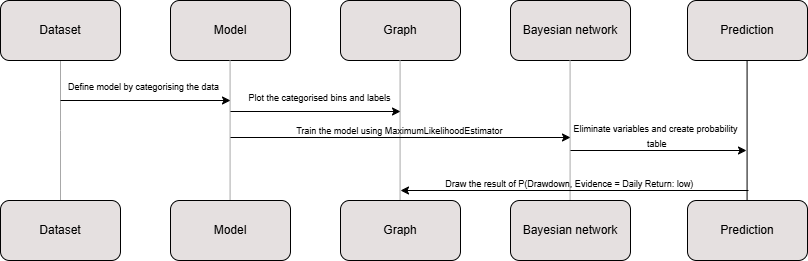


---



---

In [ ]:
!pip install pgmpy


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

df = pd.read_csv("teslastock_drawdown.csv")
print(df.head())


    Close    Open    High     Low        Date  Daily return  Target  \
0  113.64  109.11  114.59  107.52  04/01/2023      5.124884       1   
1  110.34  110.51  111.75  107.16  05/01/2023     -2.903907       0   
2  113.06  103.00  114.39  101.81  06/01/2023      2.465108       1   
3  119.77  118.96  123.52  117.11  09/01/2023      5.934902       1   
4  118.85  121.07  122.76  114.92  10/01/2023     -0.768139       0   

   Running_Max  Drawdown  Max_Drawdown  Cumulative_Max  
0       113.64  0.000000      0.000000          113.64  
1       113.64 -2.903907     -2.903907          113.64  
2       113.64 -0.510384     -2.903907          113.64  
3       119.77  0.000000     -2.903907          119.77  
4       119.77 -0.768139     -2.903907          119.77  


In [ ]:
# Define the Bayesian Network structure
model = BayesianNetwork([
    ('Daily Return', 'Drawdown'),
    ('Drawdown', 'Max_Drawdown')
])

#A=Daily return B=Drawdown C=Max_Drawdown
#A --> B --> C
#P(A,B,C) = P(A) P(B|A) P(C|B)

In [ ]:
def categorize_column(series, bins, labels):
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# Define bins and labels for categorization
daily_return_bins = [-float('inf'), -2, 0, 2, float('inf')]
drawdown_bins = [-float('inf'), -10, -5, 0, float('inf')]

# Categorize columns
df['Daily Return'] = categorize_column(df['Daily return'], daily_return_bins, ['Very Low', 'Low', 'Medium', 'High'])
df['Drawdown'] = categorize_column(df['Drawdown'], drawdown_bins, ['Very High', 'High', 'Medium', 'Low'])
df['Max_Drawdown'] = categorize_column(df['Max_Drawdown'], drawdown_bins, ['Very High', 'High', 'Medium', 'Low'])

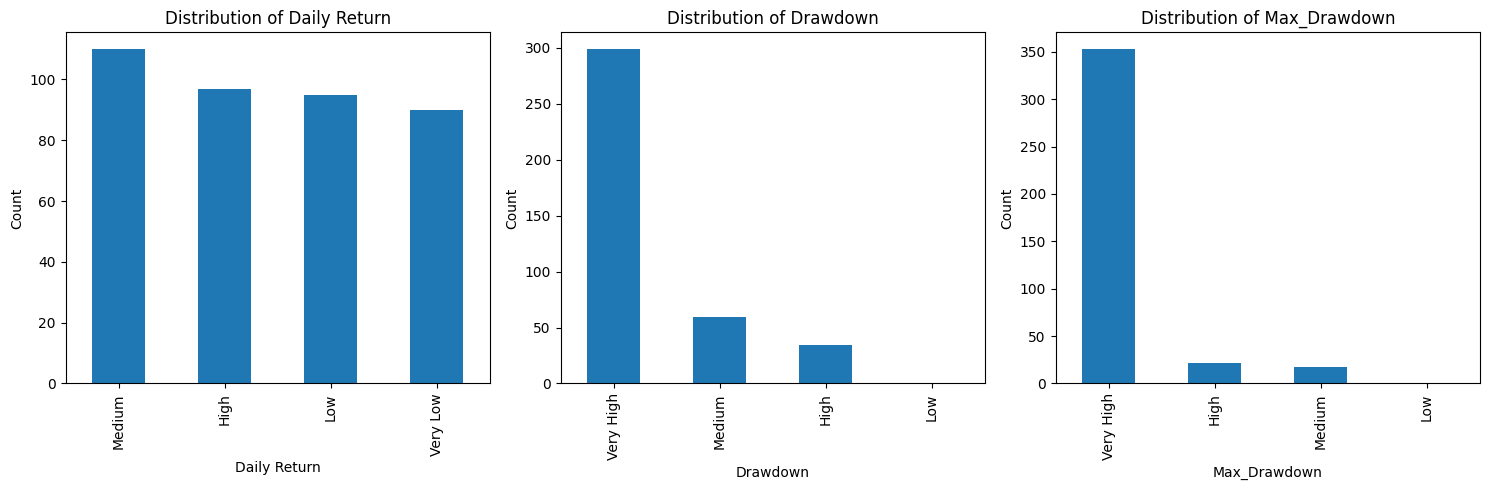

In [ ]:
# Plot histograms of categorized data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, column in zip(axes, ['Daily Return', 'Drawdown', 'Max_Drawdown']):
    df[column].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# Train the Bayesian Network
model.fit(df, estimator=MaximumLikelihoodEstimator)

In [ ]:
# Inference: Predict drawdown risk
inference = VariableElimination(model)
evidence = {'Daily Return': 'Very Low'}
drawdown_risk = inference.query(variables=['Drawdown'], evidence=evidence)

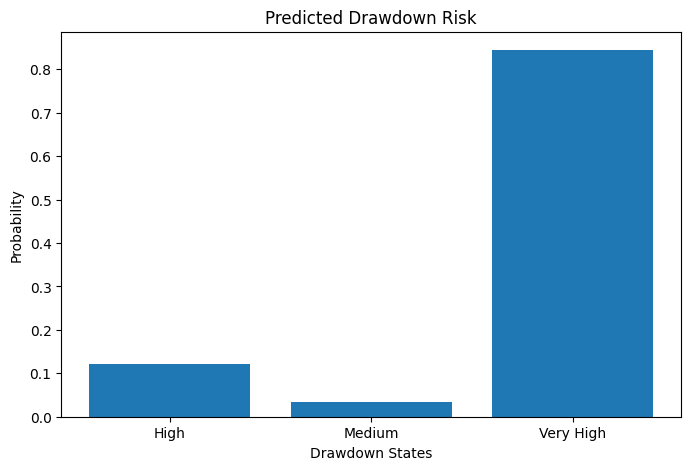

Predicted Drawdown Risk given evidence:
+---------------------+-----------------+
| Drawdown            |   phi(Drawdown) |
+=====================+=================+
| Drawdown(High)      |          0.1222 |
+---------------------+-----------------+
| Drawdown(Medium)    |          0.0333 |
+---------------------+-----------------+
| Drawdown(Very High) |          0.8444 |
+---------------------+-----------------+


In [ ]:
# Plot the predicted probabilities
drawdown_risk_values = drawdown_risk.values
labels = drawdown_risk.state_names['Drawdown']

plt.figure(figsize=(8, 5))
plt.bar(labels, drawdown_risk_values)
plt.title("Predicted Drawdown Risk")
plt.xlabel("Drawdown States")
plt.ylabel("Probability")
plt.show()

print("Predicted Drawdown Risk given evidence:")
print(drawdown_risk)

In [ ]:
true_label = "Very High"
true_index = labels.index(true_label)  # Find the index of the true label in the states
true_probability = drawdown_risk_values[true_index]

# Compute NLL for this single prediction
nll_single = -np.log(true_probability)
likelihood_single = np.exp(-nll_single)

print(f"\nNegative Log-Likelihood for '{true_label}' label prediction: {nll_single}")
print(f"Likelihood for '{true_label}' label prediction: {likelihood_single}")


Negative Log-Likelihood for 'Very High' label prediction: 0.169076330043934
Likelihood for 'Very High' label prediction: 0.8444444444444444


# ***Evaluation***

I use Likelihood and Negative LikeliHood to evaluate the model's performance for the true label ('Very High' in this case) .

In this case, the model gives a probability of 0.8444 for the label "Very High", meaning it predicts the event as "Very High" with about 84.44% confidence. Using NLL to check how good the model predicted a good probability. The NLL value comes out to 0.1691. A smaller NLL indicates a more accurate prediction, as it suggests the model's predicted probability is close to the true outcome.

# *Strengths of the Implementation*

The implementation uses a Bayesian Network to model the relationships between Daily Return, Drawdown, and Max_Drawdown. A key strength of this approach is that it clearly shows how different factors are related and uses probability to predict the Drawdown risk based on the Daily Return. The model uses Maximum Likelihood Estimation (MLE) to estimate the values needed and Variable Elimination to calculate the probabilities of different Drawdown outcomes. This allows the model to give a probability for each possible Drawdown category, depending on the given data.

# *Limitations of the Implementation*

The NLL is computed for a single sample ("Very High" Drawdown), which may not provide a complete picture of the model’s performance. A more comprehensive evaluation would require computing the NLL over a larger dataset, which would help assess the overall performance of the model rather than evaluating it for just one outcome.